# SENSEI in situ example with Catalyst

In this notebook we will explore running a miniapp, intrumented with SENSEI, that simulates atomic oscillators. We will use the SENSEI configurable analysis adaptor to feed data to Catalyst in situ.

Now, we can run the miniapp in batch mode (pvbatch), and pass it a configuration file to set up the oscillators.

Our test data set is pretty small, but you can imagine wanting to do this for a much larger data set.  

We will submit a job from the notebook to run and render frames on Cooley.

Once all of the frames are complete, we can encode these frames into a video using ffmpeg.

Finally, we will show the resulting video and embed it in this notebook

Paths and filenames

Create a directory on your home directory for frames and videos and point *framesDir* variable to it. 

If you cloned the repo in your home directory, you don't need to change the paths below.

** Make sure to update my_login with your username on Cooley **


In [3]:
my_login="hyunlim"

framesDir="/home/" + my_login + "/atpesc/viz/jupyter-ATPESC2018/sensei_catalyst/frames"
videoFileName="video.mp4"
xmlConfig="/home/" + my_login + "/atpesc/viz/jupyter-ATPESC2018/sensei_catalyst/oscillator.xml"
oscFile="/home/" + my_login + "/atpesc/viz/jupyter-ATPESC2018/sensei_catalyst/sample.osc"
qsubScript="/home/" + my_login + "/atpesc/viz/jupyter-ATPESC2018/sensei_catalyst/sensei.sh"

# DO NOT CHANGE THIS
binaryPath="/projects/ATPESC2018/jupyter/sensei-catalyst/bin/oscillator"

Clean up previous settings. Do not run the next cell if you need to keep settings and results from previous runs

In [ ]:
%%bash -s "$framesDir" "$videoFileName" "$xmlConfig" "$oscFile" "$qsubScript"
rm $1/*png $2 $3 $4 $5

Generate xml config file for Sensei configurable analysis adaptor.
We are going to to enable Catalyst and generate slices for each timestep of the simulation

In [4]:
%%bash -s "$xmlConfig" "$framesDir"
cat <<EOF >$1
<sensei>
  <!-- Custom Analyses-->
  <!-- Catalyst Analyses -->
  <analysis type="catalyst"
            pipeline="slice" array="data" association="cell"
            image-filename="$2/slice-%ts.png" image-width="512" image-height="512"
            slice-normal="0,0,1"
            color-range="0.0001,1.5" color-log="1"
            enabled="1" />
</sensei>
EOF

Verify xml config file


In [5]:
! cat "$xmlConfig"

<sensei>
  <!-- Custom Analyses-->
  <!-- Catalyst Analyses -->
  <analysis type="catalyst"
            pipeline="slice" array="data" association="cell"
            image-filename="/home/hyunlim/atpesc/viz/jupyter-ATPESC2018/sensei_catalyst/frames/slice-%ts.png" image-width="512" image-height="512"
            slice-normal="0,0,1"
            color-range="0.0001,1.5" color-log="1"
            enabled="1" />
</sensei>


Create file with settings for the simulation

In [6]:
%%bash -s "$oscFile"
cat <<EOF >$1
# type      center      r       omega0      zeta
damped      32 32 32    10.     3.14        .3
damped      16 32 16    10.     9.5         .1
damped      48 32 48    5.      3.14        .1
decaying    16 32 48    15      3.14
periodic    48 32 16    15      3.14
EOF

Verify simulation settings file

In [7]:
! cat "$oscFile"

# type      center      r       omega0      zeta
damped      32 32 32    10.     3.14        .3
damped      16 32 16    10.     9.5         .1
damped      48 32 48    5.      3.14        .1
decaying    16 32 48    15      3.14
periodic    48 32 16    15      3.14


Finally, we will create a script for qsub

In [8]:
%%bash -s "$qsubScript" "$binaryPath" "$xmlConfig" "$oscFile"
cat <<EOF >$1
#!/bin/bash

export DISPLAY=:0.0
mpiexec -n 8 \
 $2 \
 -f $3 \
 -b 16 \
 -t 0.2 \
 -s "128,128,128" \
 $4
 
EOF
chmod 755 $1

Verify qsub script

In [9]:
! cat "$qsubScript" 

#!/bin/bash

export DISPLAY=:0.0
mpiexec -n 8  /projects/ATPESC2018/jupyter/sensei-catalyst/bin/oscillator  -f /home/hyunlim/atpesc/viz/jupyter-ATPESC2018/sensei_catalyst/oscillator.xml  -b 16  -t 0.2  -s "128,128,128"  /home/hyunlim/atpesc/viz/jupyter-ATPESC2018/sensei_catalyst/sample.osc
 


At this point we have pretty much everything we need to run the simulation and generate images in situ

Since we're going to be submitting jobs to the queue on Cooley, we'll need to tell it what project to charge and what queue to use.

During our reservation these values should be set to:

* my_project = **"ATPESC2018"**
* queue = **"training"**

In [10]:
my_project="ATPESC2018"
queue="training"

Next we will create a batch script, passing it all of the relevant information to submit the jobs

In [11]:
%%bash -s "$my_project" "$queue" "$qsubScript"
echo $1 $2 $3
/bin/qsub -n 1 -t 30 -A $1 -q $2 $3

ATPESC2018 training /home/hyunlim/atpesc/viz/jupyter-ATPESC2018/sensei_catalyst/sensei.sh
1611253


Once we've run the above script, we can check the queue to see the state of our jobs:

In [20]:
! /bin/qstat -fu $my_login

JobID    JobName  User     Score    WallTime  QueuedTime  RunTime   Nodes  State    Location      Mode    Procs  Queue     StartTime                             
1611253  N/A      hyunlim    0.2    00:30:00  00:00:16    00:00:47  1      exiting  cc115.cooley  script  1      training  Thu Aug 09 22:14:04 2018 +0000 (UTC)  


We can also check our frames directory to see how many of the frames have completed.  Once this reaches 51, we will be finished rendering.  If you then go back to the previous cell, and check the queue again, you should see your jobs exiting (or nothing if they have already finished exiting).
    

In [21]:
! ls "$framesDir" | wc -l 

51


If we want to look at one of the frames while the simulation is still running, set *frame_number" to a valid frame number, and run the cell

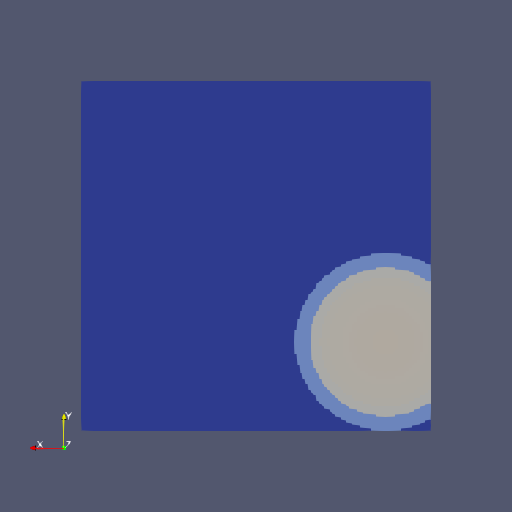

In [22]:
frame_number=0
from IPython.display import Image
Image(filename=framesDir+'/slice-'+ str(frame_number)+'.png') 

We will generate a video file now with ffmpeg. Let's use the frames generated above

In [23]:
! /soft/visualization/ffmpeg/ffmpeg -r 5 -i "$framesDir"/slice-%d.png -pix_fmt yuv420p -r 25 "$videoFileName"

ffmpeg version N-90676-g876f9ac Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 4.8.1 (GCC)
  configuration: --prefix=/projects/visualization/srizzi/ffmpeg/ffmpeg_build/ --pkg-config-flags=--static --extra-cflags=-I/projects/visualization/srizzi/ffmpeg/ffmpeg_build/include --extra-ldflags=-L/projects/visualization/srizzi/ffmpeg/ffmpeg_build/lib --extra-libs=-lpthread --extra-libs=-lm --bindir=/projects/visualization/srizzi/ffmpeg/ffmpeg_bin/ --enable-gpl --enable-libfreetype --enable-libx264 --enable-nonfree
  libavutil      56. 13.100 / 56. 13.100
  libavcodec     58. 17.100 / 58. 17.100
  libavformat    58. 11.101 / 58. 11.101
  libavdevice    58.  2.100 / 58.  2.100
  libavfilter     7. 15.100 /  7. 15.100
  libswscale      5.  0.102 /  5.  0.102
  libswresample   3.  0.101 /  3.  0.101
  libpostproc    55.  0.100 / 55.  0.100
Input #0, image2, from '/home/hyunlim/atpesc/viz/jupyter-ATPESC2018/sensei_catalyst/frames/slice-%d.png':
  Duration: 00:00:02.04, start: 0.000

Now we embed the video in HTML format so we can view it here! if all works 
we should see a video of the simulation.

In [24]:
# import modules
import io
import os
from IPython.display import HTML
# Embed the video using HTML
HTML(data='<video controls> <source src="' + videoFileName + '" type="video/mp4"> </video>') 